In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import time
import numpy as np
import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.registrationdata as regdata
import defmod.hamiltonian_multishape as hamiltonian
from defmod.energyfunctional import EnergyFunctional_unconstrained, EnergyFunctional
from defmod import optimize
import defmod.save_res as results



torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
data1 = regdata.Nut_translated(source_transvec=[0.,0.], target_transvec=[0.,0.], reflect_target=-1., undersample=2)
data1()
data2 = regdata.Nut_translated(source_transvec=[1.,3.], target_transvec=[1.,3.], reflect_target=1., undersample=2)
data2()
source = [*data1.source, *data2.source]
target = [*data1.target, *data2.target]
module_list = [*data1.modules, *data2.modules]
reduce_background = False

<Figure size 432x288 with 0 Axes>

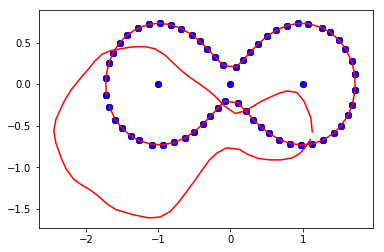

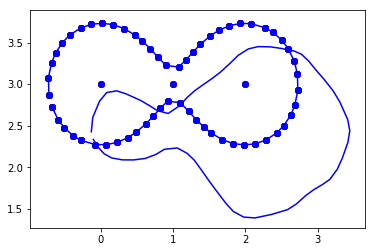

In [3]:
plt.figure()
c = ['r', 'b']
for i in range(2):
    plt.figure()
    plt.plot(source[i].detach().numpy()[:,0], source[i].detach().numpy()[:,1], c=c[i])
    for j in range(5):
        plt.scatter(module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,0],module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,1], c=c[i])

    plt.plot(target[i].detach().numpy()[:,0], target[i].detach().numpy()[:,1], c=c[i])


    for gd in module_list[i].manifold.gd:
        plt.scatter(gd.view(-1,2).detach().numpy()[:,0],gd.view(-1,2).detach().numpy()[:,1], c='r')
    for gd in module_list[i].manifold.gd:
        plt.scatter(gd.view(-1,2).detach().numpy()[:,0],gd.view(-1,2).detach().numpy()[:,1], c='b')

plt.show()

<Figure size 432x288 with 0 Axes>

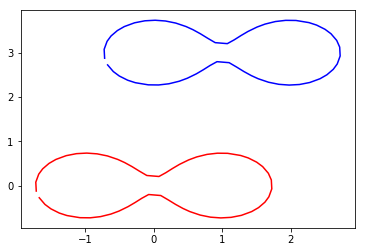

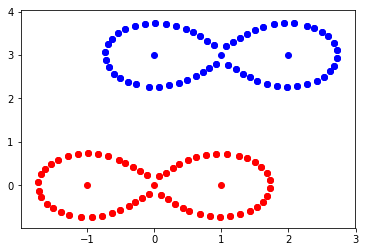

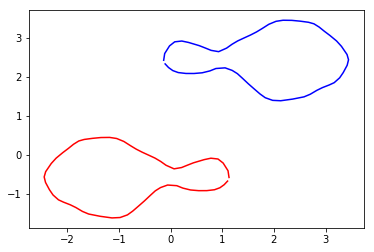

In [4]:
plt.figure()
c = ['r', 'b']

plt.figure()
for i in range(2):
    plt.plot(source[i].detach().numpy()[:,0], source[i].detach().numpy()[:,1], c=c[i])
    
plt.figure()
for i in range(2):
    for j in range(5):
        plt.scatter(module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,0],module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,1], c=c[i])

plt.figure()        
for i in range(2):
    plt.plot(target[i].detach().numpy()[:,0], target[i].detach().numpy()[:,1], c=c[i])

plt.show()

In [5]:
sigma_bg = 0.3
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr = dm.constraints.Identity_Silent()
H = dm.hamiltonian_multishape.Hamiltonian_multi(modules, constr)
def attach(modules, target):
    
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i][0].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])
E = EnergyFunctional_unconstrained(H.module, H, source, target, dim=2, gamma=1e-3, attach=attach)

In [6]:
attach(H.module, target)

tensor(25.8647, grad_fn=<AddBackward0>)

In [7]:
#sigma_bg = 0.0005
#j=0
#modules = dm.multishape.MultiShapeModule([module_list[j]], sigma_bg)

#constr = dm.constraints.Identity_Silent()
#H = dm.hamiltonian_multishape.Hamiltonian_multi(modules, constr)
#def attach(modules, target):
#    return dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[j][0].manifold.gd.view(-1,2)], [target[j]])
#E = EnergyFunctional_unconstrained(H.module, H, source, target, dim=2, gamma=1e-3, attach=attach)

In [8]:
gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]

from defmod import optimize
tic = time.time()
X[1], iter_states = optimize.BFGS(E, X, disp=True)(maxiter=100)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.0 attach: 25.864663228610674
cost: 0.0 attach: 25.864663228610674
cost: 0.005308957846958976 attach: 9.999245592837358
cost: 0.005308957846958976 attach: 9.999245592837358
cost: 0.036348931383179205 attach: 28.68495011216663
cost: 0.036348931383179205 attach: 28.68495011216663
cost: 0.009418667222067334 attach: 4.701187663302756
cost: 0.009418667222067334 attach: 4.701187663302756
cost: 0.02803603136689733 attach: 28.2936810248287
cost: 0.02803603136689733 attach: 28.2936810248287
cost: 0.010056231513169681 attach: 4.314931039515215
cost: 0.010056231513169681 attach: 4.314931039515215
cost: 0.010083843236484626 attach: 3.7867937302055914
cost: 0.010083843236484626 attach: 3.7867937302055914
cost: 0.010020884290988206 attach: 2.819746328740443
cost: 0.010020884290988206 attach: 2.819746328740443
cost: 0.010307199737060306 attach: 4.062765388389602
cost: 0.010307199737060306 attach: 4.062765388389602
cost: 0.00999857412056355 attach: 2.5306188757696706
cost: 0.00999857412056355 a

In [11]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
H.geodesic_controls()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


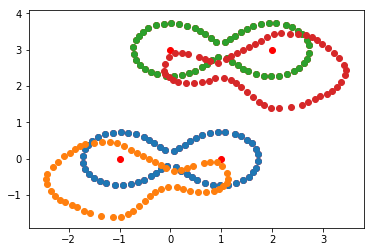

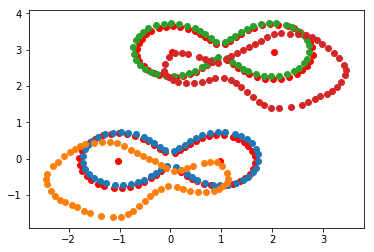

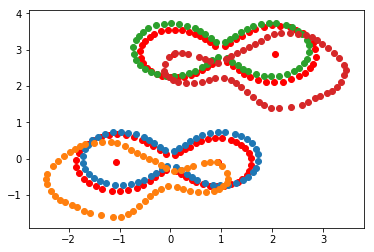

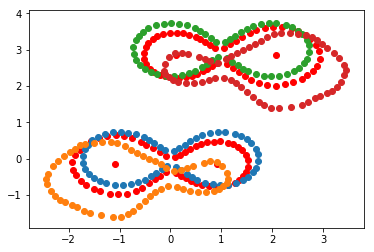

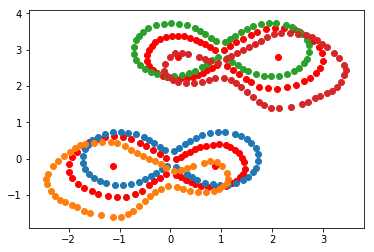

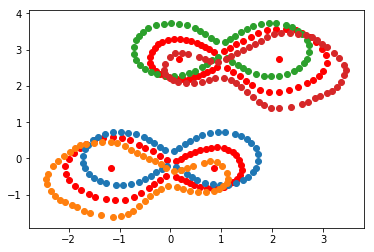

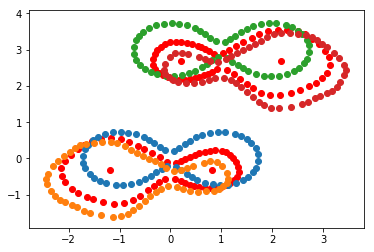

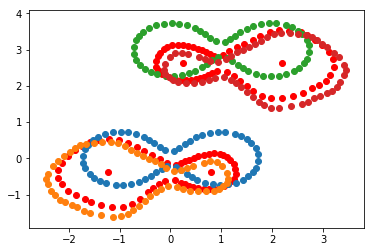

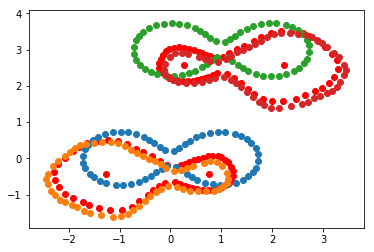

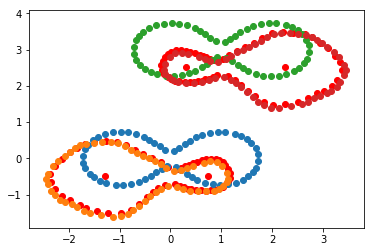

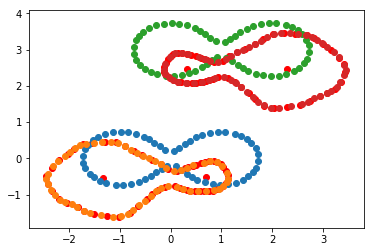

In [10]:

states, controls = dm.shooting.shoot_euler(H, it=10)


for s in states:
    plt.figure()
    for i in range(2):
        plt.scatter(s[i][0].gd.view(-1,2)[:, 0].detach().numpy(), s[i][0].gd.view(-1,2)[:, 1].detach().numpy(), c='r')
        plt.scatter(s[i][1].gd.view(-1,2)[:, 0].detach().numpy(), s[i][1].gd.view(-1,2)[:, 1].detach().numpy(), c='r')
        plt.scatter(s[i][2].gd.view(-1,2)[:, 0].detach().numpy(), s[i][2].gd.view(-1,2)[:, 1].detach().numpy(), c='r')
        plt.scatter(source[i][:,0].detach().numpy(), source[i][:,1].detach().numpy())
        plt.scatter(target[i][:,0].detach().numpy(), target[i][:,1].detach().numpy())
plt.show()

In [ ]:
import defmod.save_res as results

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)
../defmod/multishape_silentpoints.py:221: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


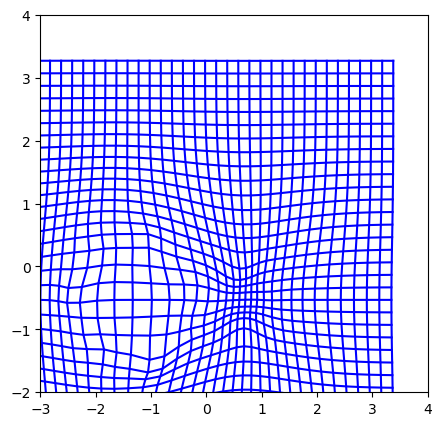

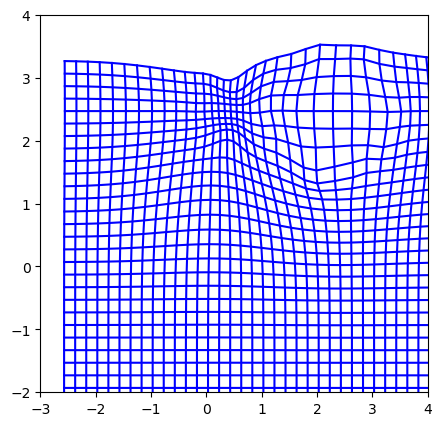

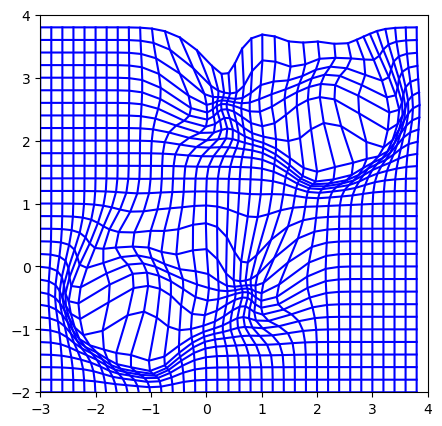

<Figure size 432x288 with 0 Axes>

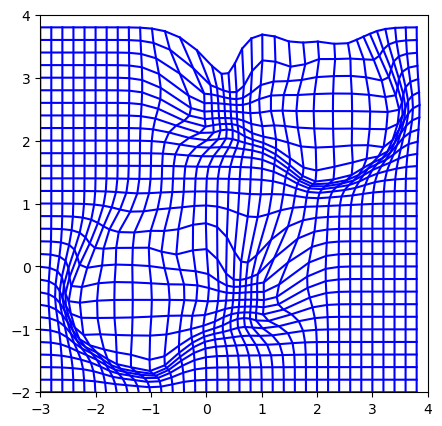

In [12]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
H.geodesic_controls()
save = results.Save_Results_MultiShape(H, source, target, E, iter_states=iter_states, time=toc-tic)

xlim = [-3, 4]
ylim = [-2,4]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)

#fig_states = save.fig_states(show=True)
fig_grid1, fig_grid2, fig_grid_bg, fig_multigrid = save.fig_grid(True)

save.save('../results/Nuts-Multi/MultiShapeDefmod/')
plt.close('all')

In [ ]:
constr_Id(H.module)

In [27]:
## LDDMM Multishape Module
sigma1 = 0.5
manifold1 = dm.manifold.Landmarks(2, len(source[0]), gd=source[0].view(-1))
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma2 = 0.5
manifold2 = dm.manifold.Landmarks(2, len(source[1]), gd=source[1].view(-1))
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)

mod2 = dm.deformationmodules.CompoundModule([silent2, trans2])

module_list = [mod1, mod2]
#sigma_bg = 
multi_LDDMM = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr = dm.constraints.Identity_Silent()
H_multi_LDDMM = dm.hamiltonian_multishape.Hamiltonian_multi(multi_LDDMM, constr)

In [28]:
Energy_multi_LDDMM = EnergyFunctional(multi_LDDMM, H_multi_LDDMM, constr, source, target, dim=2, gamma=1e-3, attach = attach)
gd0 = torch.cat(multi_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(multi_LDDMM.manifold.unroll_cotan())
X_multi_LDDMM = [gd0, mom0]

tic=time.time()
X_multi_LDDMM[1], iter_states = dm.optimize.BFGS(Energy_multi_LDDMM, X_multi_LDDMM, disp=True)(maxiter=200)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.0 attach: 25.864663228610674
cost: 0.0 attach: 25.864663228610674
cost: 0.004803353431977033 attach: 13.94279690771162
cost: 0.004803353431977033 attach: 13.94279690771162
cost: 0.24192563904470493 attach: 17.615544478138247
cost: 0.24192563904470493 attach: 17.615544478138247
cost: 0.012787783182763263 attach: 6.656492834753753
cost: 0.012787783182763263 attach: 6.656492834753753
cost: 0.03667650713444273 attach: 39.63636873881748
cost: 0.03667650713444273 attach: 39.63636873881748
cost: 0.013988660220720952 attach: 6.201169343201493
cost: 0.013988660220720952 attach: 6.201169343201493
cost: 0.014396832968966121 attach: 5.671506946396503
cost: 0.014396832968966121 attach: 5.671506946396503
cost: 0.014679758818968157 attach: 4.879972620645599
cost: 0.014679758818968157 attach: 4.879972620645599
cost: 0.015153173208528757 attach: 4.191439834689139
cost: 0.015153173208528757 attach: 4.191439834689139
cost: 0.02342737491800009 attach: 12.587879306662122
cost: 0.02342737491800009 a

cost: 0.012395373073383491 attach: 0.03256367809031957
cost: 0.012395373073383491 attach: 0.03256367809031957
cost: 0.012357866795954983 attach: 0.03135001507967061
cost: 0.012357866795954983 attach: 0.03135001507967061
cost: 0.012335400714523685 attach: 0.030369709770649678
cost: 0.012335400714523685 attach: 0.030369709770649678
cost: 0.012254007546643896 attach: 0.02979828510783733
cost: 0.012254007546643896 attach: 0.02979828510783733
cost: 0.012250223528294206 attach: 0.02899777340983256
cost: 0.012250223528294206 attach: 0.02899777340983256
cost: 0.012191964147526737 attach: 0.02824719229218786
cost: 0.012191964147526737 attach: 0.02824719229218786
cost: 0.012122431972250687 attach: 0.02751762746735764
cost: 0.012122431972250687 attach: 0.02751762746735764
cost: 0.012050400677181897 attach: 0.02684314535799892
cost: 0.012050400677181897 attach: 0.02684314535799892
cost: 0.011985959443521639 attach: 0.026122283882974884
cost: 0.011985959443521639 attach: 0.026122283882974884
cost: 

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.011811380456692222 attach: 0.019710250110236416
cost: 0.01181175155702319 attach: 0.019707525203736864
cost: 0.011813593032513304 attach: 0.019725042606806298
cost: 0.01181026198872882 attach: 0.019713239963234486
cost: 0.011813388476684807 attach: 0.01969021684113592
cost: 0.011813388476684807 attach: 0.01969021684113592
cost: 0.011811812710068424 attach: 0.019673194203564393
cost: 0.011811812710068424 attach: 0.019673194203564393


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.011817567201233701 attach: 0.01964438404298896
cost: 0.011817567201233701 attach: 0.01964438404298896
cost: 0.011805273421403127 attach: 0.019506065052784294
cost: 0.011805273421403127 attach: 0.019506065052784294
cost: 0.011807304491609251 attach: 0.019398012805499576
cost: 0.011807304491609251 attach: 0.019398012805499576
cost: 0.011799416899800729 attach: 0.019299981791363052
cost: 0.011799416899800729 attach: 0.019299981791363052
cost: 0.011826190424340488 attach: 0.019147527216297533
cost: 0.011826190424340488 attach: 0.019147527216297533
cost: 0.011796063198717606 attach: 0.019044907804730116
cost: 0.011796063198717606 attach: 0.019044907804730116
cost: 0.0118147631123909 attach: 0.018925673990068503
cost: 0.0118147631123909 attach: 0.018925673990068503
cost: 0.011787223990796904 attach: 0.0188288723008192
cost: 0.011787223990796904 attach: 0.0188288723008192
cost: 0.01177928469862954 attach: 0.018657390694459153
cost: 0.01177928469862954 attach: 0.018657390694459153
cost

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.012374935533464027 attach: 0.012723352069022198
cost: 0.012364985719903233 attach: 0.012710641201458373
cost: 0.012364985719903233 attach: 0.012710641201458373
cost: 0.0123648815381605 attach: 0.012721315063243921
cost: 0.012368888968251439 attach: 0.012719673406445864
cost: 0.012377254332483066 attach: 0.012724455464852014
cost: 0.012369708406658863 attach: 0.012703023350114862
cost: 0.012369708406658863 attach: 0.012703023350114862


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.012376132953821227 attach: 0.01271938584704202
cost: 0.012376132953821227 attach: 0.01271938584704202
cost: 0.012370535466222656 attach: 0.01273004082150031
cost: 0.012370535466222656 attach: 0.01273004082150031
cost: 0.012375190951566644 attach: 0.012717763001733218
cost: 0.012375190951566644 attach: 0.012717763001733218
cost: 0.012370816388432349 attach: 0.012723958731926999
cost: 0.012370816388432349 attach: 0.012723958731926999
cost: 0.012377239032754683 attach: 0.012728100069518078
cost: 0.012377239032754683 attach: 0.012728100069518078
cost: 0.012369708406658863 attach: 0.012703023350114862
cost: 0.012369708406658863 attach: 0.012703023350114862
cost: 0.012369708406658863 attach: 0.012703023350114862
cost: 0.012369708406658863 attach: 0.012703023350114862
cost: 0.012369708406658863 attach: 0.012703023350114862
cost: 0.012369708406658863 attach: 0.012703023350114862
cost: 0.012369708406658863 attach: 0.012703023350114862
cost: 0.012369708406658863 attach: 0.012703023350114

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.012376132953821227 attach: 0.01271938584704202
cost: 0.012379742358167153 attach: 0.012735615112797305
cost: 0.012374329586240969 attach: 0.012724193563578012
cost: 0.012365763403899426 attach: 0.012722756480554764
cost: 0.012370023080400036 attach: 0.01272385151828992
cost: 0.012367376371799056 attach: 0.012714395775821785
cost: 0.01236844200322681 attach: 0.012712143595928538
cost: 0.012370087967627365 attach: 0.012715597176239157
cost: 0.01236694219343412 attach: 0.012715764608131508
cost: 0.01237211233073174 attach: 0.012727019215606816
cost: 0.012382865714578717 attach: 0.012731186962339436
cost: 0.012366515994153861 attach: 0.012727308054579112
         Current function value: 0.025073
         Iterations: 150
         Function evaluations: 221
         Gradient evaluations: 201


In [29]:
H_multi_LDDMM.module.manifold.fill_gd(X_multi_LDDMM[0])
H_multi_LDDMM.module.manifold.fill_cotan(X_multi_LDDMM[1])
H_multi_LDDMM.geodesic_controls()
save = results.Save_Results_MultiShape(H_multi_LDDMM, source, target, Energy_multi_LDDMM, time=toc-tic, iter_states=iter_states)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape_silentpoints.py:221: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


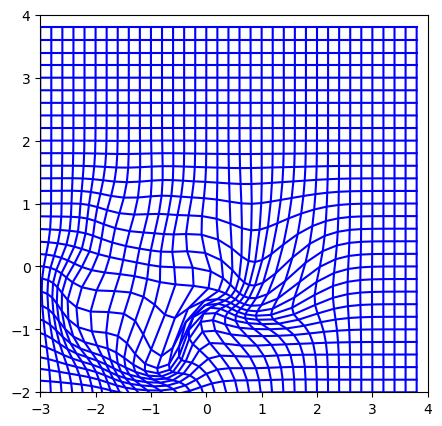

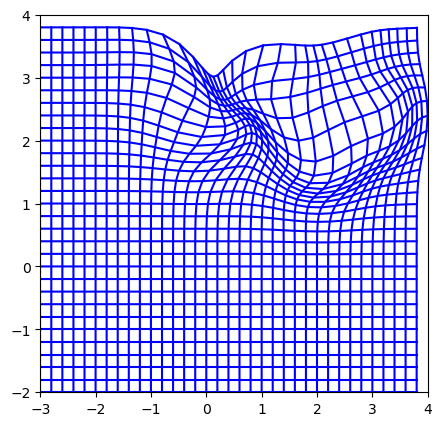

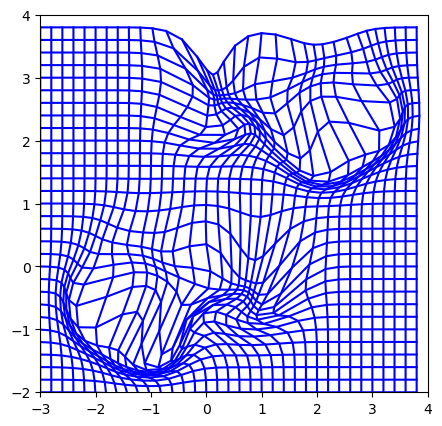

<Figure size 432x288 with 0 Axes>

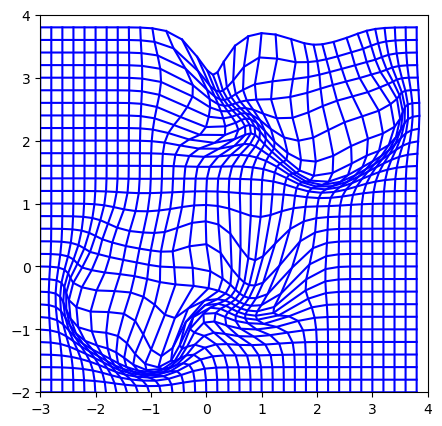

In [31]:
xlim = [-3, 4]
ylim = [-2,4]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

save.save('../results/Nuts-Multi/MultiShapeLDDMM/')
plt.close('all')

tensor(25.8647, grad_fn=<AddBackward0>)

In [54]:
## LDDMM Module

manifold1 = dm.manifold.Landmarks(2, len(source[0]), gd=source[0].view(-1))
manifold2 = dm.manifold.Landmarks(2, len(source[1]), gd=source[1].view(-1))

module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man, sigma=0.5) for man in [manifold1, manifold2]])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

def attach(modules, target): 
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])


reg_param = 1e-3
Energy_LDDMM = EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, source, target, dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

tic=time.time()
X_LDDMM[1], iter_states = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=2500)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.0 attach: 25.864663228610674
cost: 0.0 attach: 25.864663228610674
cost: 0.00481635023002091 attach: 20.912040986889764
cost: 0.00481635023002091 attach: 20.912040986889764
cost: 0.007828652682171124 attach: 19.468153427044083
cost: 0.007828652682171124 attach: 19.468153427044083
cost: 0.00867814756239808 attach: 17.96985483738943
cost: 0.00867814756239808 attach: 17.96985483738943
cost: 0.009545837506256863 attach: 15.524464900125498
cost: 0.009545837506256863 attach: 15.524464900125498
cost: 0.012095884274300158 attach: 15.26967721790917
cost: 0.012095884274300158 attach: 15.26967721790917
cost: 0.010338629498809258 attach: 14.013167819382456
cost: 0.010338629498809258 attach: 14.013167819382456
cost: 0.011777679670569903 attach: 11.977132792857208
cost: 0.011777679670569903 attach: 11.977132792857208
cost: 0.014312463511193124 attach: 11.49841887799958
cost: 0.014312463511193124 attach: 11.49841887799958
cost: 0.012827682264270432 attach: 10.683707412615583
cost: 0.0128276822

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.015814137862430966 attach: 1.0962668744517785
cost: 0.01571712723777775 attach: 0.9617491495586901
cost: 0.01571712723777775 attach: 0.9617491495586901
cost: 0.015765620364609493 attach: 0.916850870373036
cost: 0.015765620364609493 attach: 0.916850870373036
cost: 0.015789701012924963 attach: 0.899595328003933
cost: 0.015789701012924963 attach: 0.899595328003933


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.015983174044189523 attach: 0.7575621922689493
cost: 0.015983174044189523 attach: 0.7575621922689493
cost: 0.016469508047788448 attach: 0.550761063132521
cost: 0.016469508047788448 attach: 0.550761063132521
cost: 0.017504096367510925 attach: 0.5013402122843562
cost: 0.017504096367510925 attach: 0.5013402122843562
cost: 0.016972714044681213 attach: 1.1382347171291798
cost: 0.016972714044681213 attach: 1.1382347171291798
cost: 0.017502775666002543 attach: 0.5011987198383618
cost: 0.017502775666002543 attach: 0.5011987198383618
cost: 0.017246234701607823 attach: 0.4406391583340046
cost: 0.017246234701607823 attach: 0.4406391583340046
cost: 0.017242159658680086 attach: 1.9966161300140204
cost: 0.017242159658680086 attach: 1.9966161300140204
cost: 0.01724574440631799 attach: 0.4372075607883268
cost: 0.01724574440631799 attach: 0.4372075607883268
cost: 0.017237692081259335 attach: 0.36559823760805976
cost: 0.017237692081259335 attach: 0.36559823760805976
cost: 0.017483195572290448 att

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01781293675287916 attach: 0.21570538447502408
cost: 0.01774276340849339 attach: 0.1889755318765598
cost: 0.01774276340849339 attach: 0.1889755318765598


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01790479177263358 attach: 3.4195537648249925e+27
cost: 0.01790479177263358 attach: 3.4195537648249925e+27
cost: 0.01774276340849339 attach: 0.1889755318765598
cost: 0.01774276340849339 attach: 0.1889755318765598
cost: 0.01774276340849339 attach: 0.1889755318765598
cost: 0.01774276340849339 attach: 0.1889755318765598


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01790479177263358 attach: 3.4195537648249925e+27
cost: 0.017819601660422412 attach: 0.17453969621370113
cost: 0.017819601660422412 attach: 0.17453969621370113


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01795682038275695 attach: 0.15935519693799272
cost: 0.01795682038275695 attach: 0.15935519693799272
cost: 0.018144383434906926 attach: 0.1474512407106996
cost: 0.018144383434906926 attach: 0.1474512407106996
cost: 0.019179099681890178 attach: 0.5600998301120743
cost: 0.019179099681890178 attach: 0.5600998301120743
cost: 0.018436119762915617 attach: 0.19248254437209233
cost: 0.018436119762915617 attach: 0.19248254437209233
cost: 0.018235787337521847 attach: 4.348427444157977
cost: 0.018235787337521847 attach: 4.348427444157977
cost: 0.01814469968629894 attach: 0.14752685539883537
cost: 0.01814469968629894 attach: 0.14752685539883537
cost: 0.018219814876779806 attach: 0.3128681729423377
cost: 0.018219814876779806 attach: 0.3128681729423377
cost: 0.018166840322979133 attach: 0.14089265226072634
cost: 0.018166840322979133 attach: 0.14089265226072634
cost: 0.018232354765050546 attach: 0.12993263891803863
cost: 0.018232354765050546 attach: 0.12993263891803863
cost: 0.0184398101496683

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01843981014966831 attach: 0.21302020259253673
cost: 0.018252735744777728 attach: 0.12777929604277638
cost: 0.018252735744777728 attach: 0.12777929604277638
cost: 0.01829060850161465 attach: 0.12439274107335763
cost: 0.01829060850161465 attach: 0.12439274107335763


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.018392743834580897 attach: 0.11594289205599573
cost: 0.018392743834580897 attach: 0.11594289205599573
cost: 0.018709434312547537 attach: 0.12218129808235467
cost: 0.018709434312547537 attach: 0.12218129808235467
cost: 0.018548718597825895 attach: 0.11025753833854779
cost: 0.018548718597825895 attach: 0.11025753833854779
cost: 0.01884276440569554 attach: 0.11031657786423033
cost: 0.01884276440569554 attach: 0.11031657786423033
cost: 0.018687847370615785 attach: 14.35682532641499
cost: 0.018687847370615785 attach: 14.35682532641499
cost: 0.018594158595998025 attach: 0.10880989484272696
cost: 0.018594158595998025 attach: 0.10880989484272696
cost: 0.018667513954961055 attach: 0.10629380313817549
cost: 0.018667513954961055 attach: 0.10629380313817549
cost: 0.018869569532074693 attach: 0.1156774821472375
cost: 0.018869569532074693 attach: 0.1156774821472375
cost: 0.018748841680580015 attach: 0.10499242779399509
cost: 0.018748841680580015 attach: 0.10499242779399509
cost: 0.0188207395

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019616975616862094 attach: 0.9377219834751536
cost: 0.01951324411332559 attach: 0.08637172366540824
cost: 0.01951324411332559 attach: 0.08637172366540824


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01956660087202236 attach: 0.08271586127078479
cost: 0.01956660087202236 attach: 0.08271586127078479
cost: 0.019785084228403547 attach: 0.08123163479926454
cost: 0.019785084228403547 attach: 0.08123163479926454
cost: 0.019891610700172292 attach: 0.22936942847493924
cost: 0.019891610700172292 attach: 0.22936942847493924
cost: 0.01978510641624412 attach: 0.08129050517150205
cost: 0.01978510641624412 attach: 0.08129050517150205
cost: 0.01978508426234047 attach: 0.08129108175363875
cost: 0.01978508426234047 attach: 0.08129108175363875
cost: 0.019785084228404123 attach: 0.08131750525097026
cost: 0.019785084228404123 attach: 0.08131750525097026
cost: 0.019785084228403547 attach: 0.08123163479926454
cost: 0.019785084228403547 attach: 0.08123163479926454
cost: 0.019785084228403547 attach: 0.08123163479926454
cost: 0.019785084228403547 attach: 0.08123163479926454
cost: 0.01978508422840605 attach: 0.08123889494696357
cost: 0.01978508422840605 attach: 0.08123889494696357
cost: 0.0197850842

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019891610700172292 attach: 0.22936942847493924
cost: 0.019837823842814843 attach: 0.08135258811296175
cost: 0.01981966012045387 attach: 0.08118487958564735
cost: 0.01981966012045387 attach: 0.08118487958564735


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01981998251612336 attach: 0.08075686315954655
cost: 0.01981998251612336 attach: 0.08075686315954655
cost: 0.019821272736050652 attach: 32623109.70757933
cost: 0.019821272736050652 attach: 32623109.70757933
cost: 0.019819982516125403 attach: 0.08108965644238708
cost: 0.019819982516125403 attach: 0.08108965644238708
cost: 0.01981998251612336 attach: 0.08075686315954655
cost: 0.01981998251612336 attach: 0.08075686315954655


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01981998251612336 attach: 0.08075686315954655
cost: 0.01981998251612336 attach: 0.08075686315954655
cost: 0.019820304975519037 attach: 0.08113222975226542
cost: 0.019820304975519037 attach: 0.08113222975226542
cost: 0.019820950085478233 attach: 0.08107519251376871
cost: 0.019820950085478233 attach: 0.08107519251376871
cost: 0.019822241070093703 attach: 0.08100372970356773
cost: 0.019822241070093703 attach: 0.08100372970356773
cost: 0.0198248260981135 attach: 0.08107471710369474
cost: 0.01982316498198373 attach: 0.08090683718955205
cost: 0.01982316498198373 attach: 0.08090683718955205
cost: 0.019823625782766478 attach: 0.0807847089313487
cost: 0.019823625782766478 attach: 0.0807847089313487


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019832775759847928 attach: 0.0821234093701051
cost: 0.019832775759847928 attach: 0.0821234093701051
cost: 0.019824198744422903 attach: 0.08061560046830252
cost: 0.019824198744422903 attach: 0.08061560046830252
cost: 0.019824233593567036 attach: 0.0808222453816203
cost: 0.019824233593567036 attach: 0.0808222453816203
cost: 0.019824198823307257 attach: 0.08088879808108729
cost: 0.019824198823307257 attach: 0.08088879808108729
cost: 0.0198241987444209 attach: 0.08298155294668419
cost: 0.0198241987444209 attach: 0.08298155294668419
cost: 0.019824198744422903 attach: 0.08061560046830252
cost: 0.019824198744422903 attach: 0.08061560046830252


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019832775759847928 attach: 0.0821234093701051
cost: 0.01982532632098969 attach: 0.08078733510905423
cost: 0.01982442406230222 attach: 0.08081179968258745
cost: 0.019823837327338837 attach: 0.08089346034779155
cost: 0.01982373155157011 attach: 0.08086423432298773
cost: 0.019823678666298215 attach: 0.09023917030822481
cost: 0.01982365222431545 attach: 0.08089456342146484
cost: 0.01982364254670137 attach: 0.08092153796202695
cost: 0.019823634164716282 attach: 0.08038389893606102
cost: 0.019823634164716282 attach: 0.08038389893606102


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019828014117523083 attach: 0.19270084723435765
cost: 0.019828014117523083 attach: 0.19270084723435765
cost: 0.01982363890878485 attach: 0.08089642457457025
cost: 0.01982363890878485 attach: 0.08089642457457025
cost: 0.01982363416606603 attach: 0.08087028266311869
cost: 0.01982363416606603 attach: 0.08087028266311869
cost: 0.01982363416471628 attach: 0.08086380569300644
cost: 0.01982363416471628 attach: 0.08086380569300644
cost: 0.019823634164716282 attach: 0.08038389893606102
cost: 0.019823634164716282 attach: 0.08038389893606102
cost: 0.019823634164716282 attach: 0.08038389893606102
cost: 0.019823634164716282 attach: 0.08038389893606102
cost: 0.019823634164714866 attach: 0.08087474058495303
cost: 0.019823634164714866 attach: 0.08087474058495303
cost: 0.019823634164716282 attach: 0.08038389893606102
cost: 0.019823634164716282 attach: 0.08038389893606102
cost: 0.019823634164716282 attach: 0.08038389893606102
cost: 0.019823634164716282 attach: 0.08038389893606102
cost: 0.01982363

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019828014117523083 attach: 0.19270084723435765
cost: 0.019825819335244747 attach: 0.08049247903158374
cost: 0.019825078869640286 attach: 0.08470601398290789
cost: 0.019824355991227442 attach: 0.08074784399865464
cost: 0.019823887219604625 attach: 0.08083048122438363
cost: 0.01982376067598559 attach: 0.28813009453401683
cost: 0.019823697416303642 attach: 0.18548910129871743
cost: 0.019823665789502794 attach: 0.08086475568066831
cost: 0.019823654853457003 attach: 1.9010728404258357
cost: 0.019823644508980696 attach: 0.08415537219151936
cost: 0.019823641003234596 attach: 0.14087283427414654
cost: 0.019823637583962266 attach: 0.08097180868481857
         Current function value: 0.100208
         Iterations: 88
         Function evaluations: 263
         Gradient evaluations: 235


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


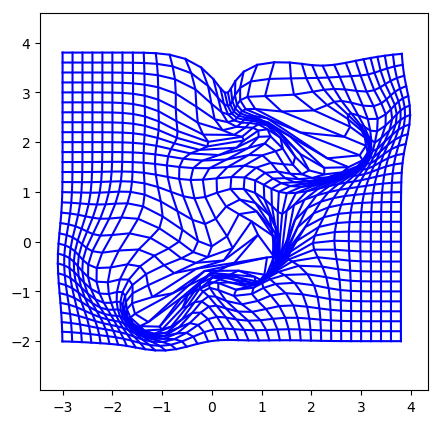

[<Figure size 500x500 with 1 Axes>]

In [57]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target, Energy_LDDMM, time=toc-tic, iter_states=iter_states)

xlim = [-3, 4]
ylim = [-2,4]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

In [58]:
save.save('../results/Nuts-Multi/LDDMM/')
plt.close('all')

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


In [82]:
data1 = regdata.Nut_translated(source_transvec=[0.,0.], target_transvec=[0.,0.], reflect_target=-1., undersample=2)
data1()
data2 = regdata.Nut_translated(source_transvec=[1.,3.], target_transvec=[1.,3.], reflect_target=1., undersample=2)
data2()
source = [*data1.source, *data2.source]
target = [*data1.target, *data2.target]
module_list = [*data1.modules, *data2.modules]
reduce_background = False

In [83]:
## Unconstrained Compound Module

module_compound = dm.deformationmodules.CompoundModule([*data1.modules, *data2.modules])
H_compound = dm.hamiltonian.Hamiltonian(module_compound)

def attach(modules, target): 
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[5*i].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])

Energy_compound = EnergyFunctional_unconstrained(module_compound, H_compound, source, target, dim=2, gamma=1e-3, attach=attach)
gd0_c = torch.cat(module_compound.manifold.unroll_gd())
mom0_c = torch.cat(module_compound.manifold.unroll_cotan())
X_compound = [gd0_c, mom0_c]

In [84]:
attach(H_compound.module, target)

tensor(25.8647, grad_fn=<AddBackward0>)

In [85]:
tic=time.time()
X_compound[1], iter_states = dm.optimize.BFGS(Energy_compound, X_compound, disp=True)(maxiter=2000)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.0 attach: 25.864663228610674
cost: 0.0 attach: 25.864663228610674
cost: 0.05049736745607101 attach: 94.42458951583936
cost: 0.05049736745607101 attach: 94.42458951583936
cost: 0.001877918432571922 attach: 29.658358362765284
cost: 0.001877918432571922 attach: 29.658358362765284
cost: 0.0003428408125599957 attach: 16.042914836464842
cost: 0.0003428408125599957 attach: 16.042914836464842
cost: 0.004116165556497807 attach: 23.306936164203883
cost: 0.004116165556497807 attach: 23.306936164203883
cost: 0.0008022456541918532 attach: 13.432447857313242
cost: 0.0008022456541918532 attach: 13.432447857313242
cost: 0.056594169458584455 attach: 91.5907354933645
cost: 0.056594169458584455 attach: 91.5907354933645
cost: 0.0008099756581336312 attach: 13.450714573454071
cost: 0.0008099756581336312 attach: 13.450714573454071
cost: 0.0008035680488113562 attach: 13.421284109416401
cost: 0.0008035680488113562 attach: 13.421284109416401
cost: 0.0008042252149737106 attach: 13.398829731680927
cost: 0

cost: 0.019588838766435017 attach: 0.007142318305293216
cost: 0.01959332942276373 attach: 0.007012720802796579
cost: 0.01959332942276373 attach: 0.007012720802796579
cost: 0.019603561594856822 attach: 0.006874862374349533
cost: 0.019603561594856822 attach: 0.006874862374349533
cost: 0.019605252793744747 attach: 0.0067378633554060485
cost: 0.019605252793744747 attach: 0.0067378633554060485
cost: 0.01960576295757787 attach: 0.006630692755386747
cost: 0.01960576295757787 attach: 0.006630692755386747
cost: 0.019600508365508428 attach: 0.006553960782531121
cost: 0.019600508365508428 attach: 0.006553960782531121
cost: 0.019592461606739952 attach: 0.006497495094622607
cost: 0.019592461606739952 attach: 0.006497495094622607
cost: 0.019585512384252247 attach: 0.006423873074441033
cost: 0.019585512384252247 attach: 0.006423873074441033
cost: 0.019576505535587756 attach: 0.006342711464959905
cost: 0.019576505535587756 attach: 0.006342711464959905
cost: 0.019569205749158283 attach: 0.0062465423376

KeyboardInterrupt: 

In [86]:
H_compound.module.manifold.fill_gd(X_compound[0])
H_compound.module.manifold.fill_cotan(X_compound[1])
H_compound.geodesic_controls()
save = results.Save_Results_SingleShape(H_compound, source, target, Energy_compound, time=toc-tic, iter_states=iter_states)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


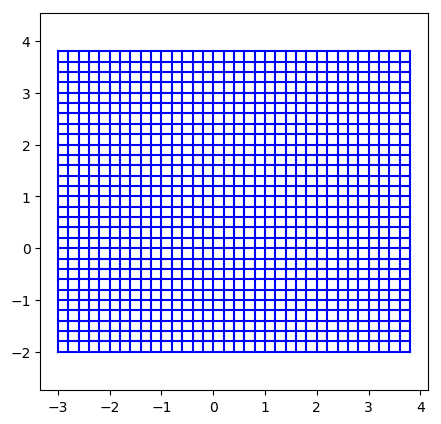

In [87]:
xlim = [-3, 4]
ylim = [-2,4]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

save.save('../results/Nuts-Multi/Compound/')
plt.close('all')

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd().copy()).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan().copy()).requires_grad_().view(-1)


test_gradcheck_Hamiltonian()